In [1]:
import pandas as pd
import os

In [2]:
path = os.path.abspath('')
path = path + "/engineered_data_250ms_window80_step8.csv"
df = pd.read_csv(path)


diction = {'Dany':0, 'Felix':1, 'Julian':2, 'Mark':3,'Martin':4,'Michele':5,'Paul':6}

for index,row in df['Participant'].items():
    df.loc[index,'Participant'] = diction[row]

List = ["Window", "Participant", "Run", "Path"]
for name in df.columns:
    if "Acceleration" in name and not "Linear" in name:
        List.append(name)

df.drop(df.columns.difference(List),axis=1,inplace=True)
df.columns

Index(['Window', 'Participant', 'Path', 'Run',
       'median_Acceleration x (m/s^2)_head_mean',
       'median_Acceleration x (m/s^2)_head_std',
       'median_Acceleration x (m/s^2)_head_last',
       'median_Acceleration x (m/s^2)_head_get_freq',
       'median_Acceleration x (m/s^2)_head_get_weighted_freq',
       'median_Acceleration x (m/s^2)_head_get_power_spectral_entropy',
       'median_Acceleration y (m/s^2)_head_mean',
       'median_Acceleration y (m/s^2)_head_std',
       'median_Acceleration y (m/s^2)_head_last',
       'median_Acceleration y (m/s^2)_head_get_freq',
       'median_Acceleration y (m/s^2)_head_get_weighted_freq',
       'median_Acceleration y (m/s^2)_head_get_power_spectral_entropy',
       'median_Acceleration z (m/s^2)_head_mean',
       'median_Acceleration z (m/s^2)_head_std',
       'median_Acceleration z (m/s^2)_head_last',
       'median_Acceleration z (m/s^2)_head_get_freq',
       'median_Acceleration z (m/s^2)_head_get_weighted_freq',
       'med

In [3]:
#create train/test set
#should maybe do random runs in the future
X_Train = df[df['Run'] < 4].copy()
X_Train
X_Test = df[df['Run'] == 4].copy()

Y_Train = X_Train['Participant'].copy()

Y_Test = X_Test['Participant'].copy()
X_Test.drop(['Participant'],axis=1,inplace=True)
X_Train.drop(['Participant'],axis=1,inplace=True)
X_Train.loc[X_Train['Path'] == 'circle', "Path"] = 1
X_Train
X_Train.loc[X_Train['Path'] == 'straight', "Path"] = 0
X_Test.loc[X_Test['Path'] == 'circle',"Path"] = 1
X_Train
X_Test.loc[X_Test['Path'] == 'straight',"Path"] = 0
X_Train

,Window,Path,Run,median_Acceleration x (m/s^2)_head_mean,median_Acceleration x (m/s^2)_head_std,median_Acceleration x (m/s^2)_head_last,median_Acceleration x (m/s^2)_head_get_freq,median_Acceleration x (m/s^2)_head_get_weighted_freq,median_Acceleration x (m/s^2)_head_get_power_spectral_entropy,median_Acceleration y (m/s^2)_head_mean,...,median_Acceleration y (m/s^2)_head_last,median_Acceleration y (m/s^2)_head_get_freq,median_Acceleration y (m/s^2)_head_get_weighted_freq,median_Acceleration y (m/s^2)_head_get_power_spectral_entropy,median_Acceleration z (m/s^2)_head_mean,median_Acceleration z (m/s^2)_head_std,median_Acceleration z (m/s^2)_head_last,median_Acceleration z (m/s^2)_head_get_freq,median_Acceleration z (m/s^2)_head_get_weighted_freq,median_Acceleration z (m/s^2)_head_get_power_spectral_entropy
0,1,1,1,-1.441885,1.664816,0.079860,0.0000,0.145976,2.644804,2.365933,...,4.797909,0.0,0.129416,2.071018,9.072312,0.704681,8.513065,0.0,0.050999,0.042980
1,2,1,1,-1.354020,1.668913,-1.607379,0.0000,0.152539,2.750950,2.793587,...,2.652444,0.0,0.122570,1.492870,9.008865,0.690520,9.079565,0.0,0.050340,0.041829
2,3,1,1,-1.276945,1.523551,-1.642075,0.0000,0.149108,2.703146,2.807282,...,3.206981,0.0,0.121614,1.480909,9.042798,0.696329,9.366405,0.0,0.051699,0.042340
3,4,1,1,-1.242948,1.392956,-2.495415,0.0000,0.150805,2.605224,2.928991,...,1.944168,0.0,0.117329,1.327042,9.033597,0.636086,9.246166,0.0,0.046729,0.036069
4,5,1,1,-1.288124,1.336146,-1.344168,0.0000,0.152741,2.364361,2.821717,...,2.832504,0.0,0.120923,1.344156,9.084389,0.627959,9.212367,0.0,0.044890,0.035065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301,28,0,3,-1.435649,1.551049,0.448056,0.0000,0.167106,2.127912,2.976787,...,2.489134,0.0,0.128121,1.610478,8.822307,1.467203,10.273584,0.0,0.106711,0.158179
1302,29,0,3,-1.293418,1.718175,2.827120,0.0000,0.165010,2.700931,2.772036,...,5.612365,0.0,0.143186,1.864197,8.896455,1.409996,7.843374,0.0,0.099032,0.146541
1303,30,0,3,-1.085459,1.779832,1.439881,0.0000,0.161288,3.135314,3.214193,...,5.775377,0.0,0.133831,1.527957,8.752814,1.292409,7.817053,0.0,0.097040,0.132847
1304,31,0,3,-0.873713,1.808765,0.369691,0.0000,0.164181,3.253732,3.486844,...,5.837291,0.0,0.132983,1.356970,8.692852,1.211373,7.888538,0.0,0.092626,0.120462


In [26]:
# from sklearn import svm
# #rbf = svm.SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X_train, y_train)

# clf = svm.SVC(kernel='rbf',gamma=0.5,C=0.1)
# poly = svm.SVC(kernel='poly', degree=20, C=1)
# clf.fit(X_Train,Y_Train)
# poly.fit(X_Train,Y_Train)
# y_pred = clf.predict(X_Test)
# y_pred_poly = poly.predict(X_Test)
# print(y_pred)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(Y_Test , y_pred))
print("Accuracy:",metrics.accuracy_score(Y_Test , y_pred_poly))


In [4]:
X_Train.dtypes

Window                                                             int64
Path                                                              object
Run                                                                int64
median_Acceleration x (m/s^2)_head_mean                          float64
median_Acceleration x (m/s^2)_head_std                           float64
median_Acceleration x (m/s^2)_head_last                          float64
median_Acceleration x (m/s^2)_head_get_freq                      float64
median_Acceleration x (m/s^2)_head_get_weighted_freq             float64
median_Acceleration x (m/s^2)_head_get_power_spectral_entropy    float64
median_Acceleration y (m/s^2)_head_mean                          float64
median_Acceleration y (m/s^2)_head_std                           float64
median_Acceleration y (m/s^2)_head_last                          float64
median_Acceleration y (m/s^2)_head_get_freq                      float64
median_Acceleration y (m/s^2)_head_get_weighted_fre

In [5]:
# convert Path column to an int representation
X_Train['Path'] = X_Train['Path'].astype(int)

X_Test['Path'] = X_Test['Path'].astype(int)







In [35]:
X_Train

,Window,Path,Run,median_Acceleration x (m/s^2)_head_mean,median_Acceleration x (m/s^2)_head_std,median_Acceleration x (m/s^2)_head_last,median_Acceleration x (m/s^2)_head_get_freq,median_Acceleration x (m/s^2)_head_get_weighted_freq,median_Acceleration x (m/s^2)_head_get_power_spectral_entropy,median_Acceleration y (m/s^2)_head_mean,...,median_Acceleration y (m/s^2)_head_last,median_Acceleration y (m/s^2)_head_get_freq,median_Acceleration y (m/s^2)_head_get_weighted_freq,median_Acceleration y (m/s^2)_head_get_power_spectral_entropy,median_Acceleration z (m/s^2)_head_mean,median_Acceleration z (m/s^2)_head_std,median_Acceleration z (m/s^2)_head_last,median_Acceleration z (m/s^2)_head_get_freq,median_Acceleration z (m/s^2)_head_get_weighted_freq,median_Acceleration z (m/s^2)_head_get_power_spectral_entropy
0,1,1,1,-1.441885,1.664816,0.079860,0.0000,0.145976,2.644804,2.365933,...,4.797909,0.0,0.129416,2.071018,9.072312,0.704681,8.513065,0.0,0.050999,0.042980
1,2,1,1,-1.354020,1.668913,-1.607379,0.0000,0.152539,2.750950,2.793587,...,2.652444,0.0,0.122570,1.492870,9.008865,0.690520,9.079565,0.0,0.050340,0.041829
2,3,1,1,-1.276945,1.523551,-1.642075,0.0000,0.149108,2.703146,2.807282,...,3.206981,0.0,0.121614,1.480909,9.042798,0.696329,9.366405,0.0,0.051699,0.042340
3,4,1,1,-1.242948,1.392956,-2.495415,0.0000,0.150805,2.605224,2.928991,...,1.944168,0.0,0.117329,1.327042,9.033597,0.636086,9.246166,0.0,0.046729,0.036069
4,5,1,1,-1.288124,1.336146,-1.344168,0.0000,0.152741,2.364361,2.821717,...,2.832504,0.0,0.120923,1.344156,9.084389,0.627959,9.212367,0.0,0.044890,0.035065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301,28,0,3,-1.435649,1.551049,0.448056,0.0000,0.167106,2.127912,2.976787,...,2.489134,0.0,0.128121,1.610478,8.822307,1.467203,10.273584,0.0,0.106711,0.158179
1302,29,0,3,-1.293418,1.718175,2.827120,0.0000,0.165010,2.700931,2.772036,...,5.612365,0.0,0.143186,1.864197,8.896455,1.409996,7.843374,0.0,0.099032,0.146541
1303,30,0,3,-1.085459,1.779832,1.439881,0.0000,0.161288,3.135314,3.214193,...,5.775377,0.0,0.133831,1.527957,8.752814,1.292409,7.817053,0.0,0.097040,0.132847
1304,31,0,3,-0.873713,1.808765,0.369691,0.0000,0.164181,3.253732,3.486844,...,5.837291,0.0,0.132983,1.356970,8.692852,1.211373,7.888538,0.0,0.092626,0.120462


Accuracy: 0.9163763066202091


<Axes: >

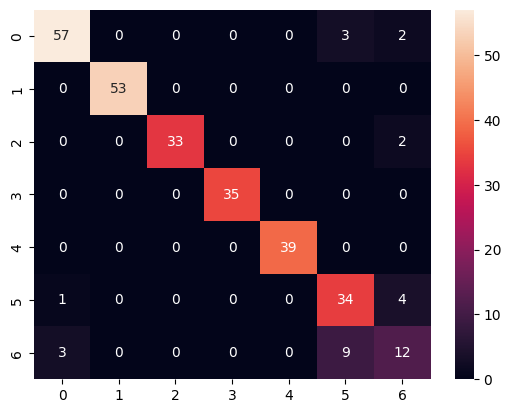

In [6]:

import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
model = XGBClassifier(tree_method = 'hist',objective='multi:softprob')
model.fit(X_Train,Y_Train)
y_pred = model.predict(X_Test)
Y_Test = Y_Test.astype('int')
print("Accuracy:",metrics.accuracy_score(Y_Test , y_pred))

cm = confusion_matrix(Y_Test,y_pred)
sns.heatmap(cm,annot=True)

In [33]:
import time
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    model, X_Test, Y_Test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
feature_names = [f"feature {i}" for i in range(X_Train.shape[1])]
forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 0.886 seconds


In [35]:
X_Train

,Window,Run,median_Acceleration x (m/s^2)_head_mean,median_Acceleration x (m/s^2)_head_std,median_Acceleration x (m/s^2)_head_last,median_Acceleration x (m/s^2)_head_get_freq,median_Acceleration x (m/s^2)_head_get_weighted_freq,median_Acceleration x (m/s^2)_head_get_power_spectral_entropy,median_Acceleration y (m/s^2)_head_mean,median_Acceleration y (m/s^2)_head_std,median_Acceleration y (m/s^2)_head_last,median_Acceleration y (m/s^2)_head_get_freq,median_Acceleration y (m/s^2)_head_get_weighted_freq,median_Acceleration y (m/s^2)_head_get_power_spectral_entropy,median_Acceleration z (m/s^2)_head_mean,median_Acceleration z (m/s^2)_head_std,median_Acceleration z (m/s^2)_head_last,median_Acceleration z (m/s^2)_head_get_freq,median_Acceleration z (m/s^2)_head_get_weighted_freq,median_Acceleration z (m/s^2)_head_get_power_spectral_entropy
0,1,1,-1.441885,1.664816,0.079860,0.0000,0.145976,2.644804,2.365933,2.210585,4.797909,0.0,0.129416,2.071018,9.072312,0.704681,8.513065,0.0,0.050999,0.042980
1,2,1,-1.354020,1.668913,-1.607379,0.0000,0.152539,2.750950,2.793587,1.964040,2.652444,0.0,0.122570,1.492870,9.008865,0.690520,9.079565,0.0,0.050340,0.041829
2,3,1,-1.276945,1.523551,-1.642075,0.0000,0.149108,2.703146,2.807282,1.956644,3.206981,0.0,0.121614,1.480909,9.042798,0.696329,9.366405,0.0,0.051699,0.042340
3,4,1,-1.242948,1.392956,-2.495415,0.0000,0.150805,2.605224,2.928991,1.895653,1.944168,0.0,0.117329,1.327042,9.033597,0.636086,9.246166,0.0,0.046729,0.036069
4,5,1,-1.288124,1.336146,-1.344168,0.0000,0.152741,2.364361,2.821717,1.841755,2.832504,0.0,0.120923,1.344156,9.084389,0.627959,9.212367,0.0,0.044890,0.035065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301,28,3,-1.435649,1.551049,0.448056,0.0000,0.167106,2.127912,2.976787,2.320433,2.489134,0.0,0.128121,1.610478,8.822307,1.467203,10.273584,0.0,0.106711,0.158179
1302,29,3,-1.293418,1.718175,2.827120,0.0000,0.165010,2.700931,2.772036,2.309047,5.612365,0.0,0.143186,1.864197,8.896455,1.409996,7.843374,0.0,0.099032,0.146541
1303,30,3,-1.085459,1.779832,1.439881,0.0000,0.161288,3.135314,3.214193,2.236805,5.775377,0.0,0.133831,1.527957,8.752814,1.292409,7.817053,0.0,0.097040,0.132847
1304,31,3,-0.873713,1.808765,0.369691,0.0000,0.164181,3.253732,3.486844,2.194027,5.837291,0.0,0.132983,1.356970,8.692852,1.211373,7.888538,0.0,0.092626,0.120462


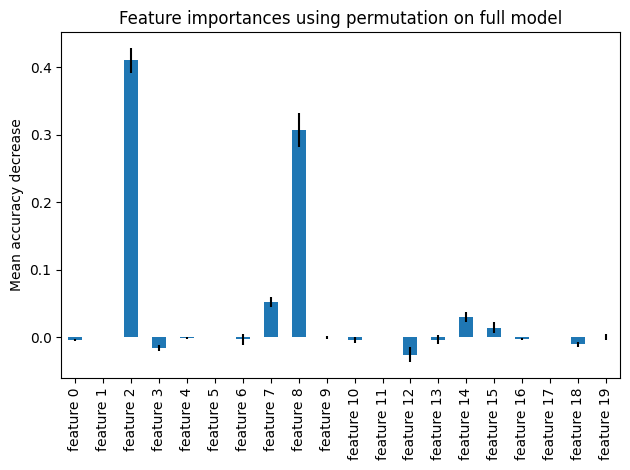

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()